# New Table

In [5]:
import pandas as pd
import re
from pathlib import Path
import math

# === Config ===
files = {
    "Sensor": Path("/Users/priyank/Desktop/llm_rag/downloads/Manual_Metrics_Top_Config_Sensor.xlsx"),
    "Valve": Path("/Users/priyank/Desktop/llm_rag/downloads/Manual_Metrics_Top_Config_Valve.xlsx"),
    "Shaft": Path("/Users/priyank/Desktop/llm_rag/downloads/Manual_Metrics_Top_Config_Shaft.xlsx"),
}

model_name_map = {
    "LLaMA-3-8B": "LLaMA-3-Instruct",
    "Mistral-7B": "Mistral-Instruct",
    "Qwen-7B": "Qwen-2.5-Instruct"
}

def extract_model_prompt_level(filename):
    parts = filename.split("_")
    model = model_name_map.get(parts[0], parts[0])
    prompt = parts[1]
    level = parts[2]
    return model, prompt, level

def process_part(path, part):
    xls = pd.ExcelFile(path)
    node_df = xls.parse("NodeMetrics")
    edge_df = xls.parse("EdgeMetrics")
    ged_df = xls.parse("GEDMetrics")

    # Normalize column names
    node_df.columns = [c.lower() for c in node_df.columns]
    edge_df.columns = [c.lower() for c in edge_df.columns]
    ged_df.columns = [c.lower() for c in ged_df.columns]

    # Filter to "overall" rows
    node_overall = node_df[node_df["role"].str.lower() == "overall"].copy()
    edge_overall = edge_df[edge_df["edge type"].str.lower() == "overall"].copy()

    # Get config keys
    node_overall["config"] = node_overall["file"].apply(lambda x: re.sub(r'_seed\d\d?_.*$', '', x))
    edge_overall["config"] = edge_overall["file"].apply(lambda x: re.sub(r'_seed\d\d?_.*$', '', x))
    ged_df["config"] = ged_df["file"].apply(lambda x: re.sub(r'_seed\d\d?_.*$', '', x))

    # === Compute metrics from TP/FP/FN ===
    def compute_f1(df):
        grouped = df.groupby("config")[["tp", "fp", "fn"]].sum()
        grouped["Precision"] = grouped["tp"] / (grouped["tp"] + grouped["fp"])
        grouped["Recall"] = grouped["tp"] / (grouped["tp"] + grouped["fn"])
        grouped["F1"] = 2 * (grouped["Precision"] * grouped["Recall"]) / (grouped["Precision"] + grouped["Recall"])
        return grouped[["F1"]].reset_index()

    node_f1 = compute_f1(node_overall).rename(columns={"F1": "Node_F1"})
    edge_f1 = compute_f1(edge_overall).rename(columns={"F1": "Edge_F1"})

    # === GED: simple average across diagrams per config
    ged_avg = ged_df.groupby("config")["ged"].mean().reset_index().rename(columns={"ged": "GED"})

    # Merge all
    merged = node_f1.merge(edge_f1, on="config").merge(ged_avg, on="config")

    # Add model, prompt, level
    merged[["Model", "Prompt", "Level"]] = merged["config"].apply(
        lambda x: pd.Series(extract_model_prompt_level(x))
    )

    # Format rounding
    merged["Node_F1"] = merged["Node_F1"].apply(lambda x: round(x, 2))
    merged["Edge_F1"] = merged["Edge_F1"].apply(lambda x: round(x, 2))
    merged["GED"] = merged["GED"].apply(lambda x: math.ceil(x))

    return merged[["Model", "Prompt", "Level", "Node_F1", "Edge_F1", "GED"]]

def to_latex_table(df, part):
    rows = []
    for _, row in df.iterrows():
        rows.append(
            f"{row['Model']} & {row['Prompt']} & {row['Level']} & "
            f"{row['Node_F1']} & {row['Edge_F1']} & {row['GED']} \\\\"
        )
    return f"""\\begin{{table}}[!h]
\\centering
\\begin{{tabular}}{{lcccccc}}
\\toprule
\\textbf{{Model}} & \\textbf{{Prompt}} & \\textbf{{Level}} & \\textbf{{Node F1}} & \\textbf{{Edge F1}} & \\textbf{{GED}} \\\\
\\midrule
{chr(10).join(rows)}
\\bottomrule
\\end{{tabular}}
\\caption{{Stochastic summary for {part} across 10 seeds (Overall-level only).}}
\\label{{tab:stochastic_{part.lower()}}}
\\end{{table}}"""

# === Run and print LaTeX for each part
for part, path in files.items():
    df = process_part(path, part)
    print(f"\n% === LaTeX table for {part} ===\n")
    print(to_latex_table(df, part))



% === LaTeX table for Sensor ===

\begin{table}[!h]
\centering
\begin{tabular}{lcccccc}
\toprule
\textbf{Model} & \textbf{Prompt} & \textbf{Level} & \textbf{Node F1} & \textbf{Edge F1} & \textbf{GED} \\
\midrule
LLaMA-3-Instruct & cot & high & 1.0 & 1.0 & 0 \\
LLaMA-3-Instruct & zero & high & 1.0 & 1.0 & 0 \\
Mistral-Instruct & cot & medium & 0.92 & 0.83 & 3 \\
Mistral-Instruct & zero & high & 1.0 & 1.0 & 0 \\
Qwen-2.5-Instruct & cot & medium & 1.0 & 1.0 & 0 \\
Qwen-2.5-Instruct & zero & medium & 1.0 & 1.0 & 0 \\
\bottomrule
\end{tabular}
\caption{Stochastic summary for Sensor across 10 seeds (Overall-level only).}
\label{tab:stochastic_sensor}
\end{table}

% === LaTeX table for Valve ===

\begin{table}[!h]
\centering
\begin{tabular}{lcccccc}
\toprule
\textbf{Model} & \textbf{Prompt} & \textbf{Level} & \textbf{Node F1} & \textbf{Edge F1} & \textbf{GED} \\
\midrule
LLaMA-3-Instruct & cot & high & 0.87 & 0.86 & 6 \\
LLaMA-3-Instruct & zero & high & 0.85 & 0.84 & 7 \\
Mistral-Instruct & 

In [1]:
import pandas as pd
import re
import math
from pathlib import Path

# === Config ===
files = {
    "Sensor": Path("/Users/priyank/Desktop/llm_rag/downloads/Manual_Metrics_Top_Config_Sensor.xlsx"),
    "Valve": Path("/Users/priyank/Desktop/llm_rag/downloads/Manual_Metrics_Top_Config_Valve.xlsx"),
    "Shaft": Path("/Users/priyank/Desktop/llm_rag/downloads/Manual_Metrics_Top_Config_Shaft.xlsx"),
}


model_name_map = {
    "LLaMA-3-8B": "LLaMA-3-Instruct",
    "Mistral-7B": "Mistral-Instruct",
    "Qwen-7B": "Qwen-2.5-Instruct"
}

def extract_model_prompt_level(filename):
    parts = filename.split("_")
    model = model_name_map.get(parts[0], parts[0])
    prompt = parts[1]
    level = parts[2]
    return model, prompt, level

def process_part(path):
    xls = pd.ExcelFile(path)
    node_df = xls.parse("NodeMetrics")
    edge_df = xls.parse("EdgeMetrics")
    ged_df = xls.parse("GEDMetrics")

    node_df.columns = [c.lower() for c in node_df.columns]
    edge_df.columns = [c.lower() for c in edge_df.columns]
    ged_df.columns = [c.lower() for c in ged_df.columns]

    node_overall = node_df[node_df["role"].str.lower() == "overall"].copy()
    edge_overall = edge_df[edge_df["edge type"].str.lower() == "overall"].copy()

    node_overall["config"] = node_overall["file"].apply(lambda x: re.sub(r'_seed\d\d?_.*$', '', x))
    edge_overall["config"] = edge_overall["file"].apply(lambda x: re.sub(r'_seed\d\d?_.*$', '', x))
    ged_df["config"] = ged_df["file"].apply(lambda x: re.sub(r'_seed\d\d?_.*$', '', x))

    def compute_f1(df):
        grouped = df.groupby("config")[["tp", "fp", "fn"]].sum()
        grouped["Precision"] = grouped["tp"] / (grouped["tp"] + grouped["fp"])
        grouped["Recall"] = grouped["tp"] / (grouped["tp"] + grouped["fn"])
        grouped["F1"] = 2 * (grouped["Precision"] * grouped["Recall"]) / (grouped["Precision"] + grouped["Recall"])
        return grouped[["F1"]].reset_index()

    node_f1 = compute_f1(node_overall).rename(columns={"F1": "Node_F1"})
    edge_f1 = compute_f1(edge_overall).rename(columns={"F1": "Edge_F1"})
    ged_avg = ged_df.groupby("config")["ged"].mean().reset_index().rename(columns={"ged": "GED"})

    merged = node_f1.merge(edge_f1, on="config").merge(ged_avg, on="config")
    merged[["Model", "Prompt", "Level"]] = merged["config"].apply(lambda x: pd.Series(extract_model_prompt_level(x)))

    return merged[["Model", "Prompt", "Level", "Node_F1", "Edge_F1", "GED"]]

# === Run
all_parts = [process_part(path) for path in files.values()]
combined = pd.concat(all_parts)

# === Average across parts
summary = combined.groupby(["Model", "Prompt", "Level"]).agg(
    Mean_Node_F1=("Node_F1", "mean"),
    Mean_Edge_F1=("Edge_F1", "mean"),
    Mean_GED=("GED", "mean")
).reset_index()

summary["Mean_Node_F1"] = summary["Mean_Node_F1"].round(2)
summary["Mean_Edge_F1"] = summary["Mean_Edge_F1"].round(2)
summary["Mean_GED"] = summary["Mean_GED"].apply(lambda x: math.ceil(x))

summary_sorted = summary.sort_values(
    by=["Mean_Node_F1", "Mean_Edge_F1", "Mean_GED"],
    ascending=[False, False, True]
).reset_index(drop=True)

print(summary_sorted)


               Model Prompt   Level  Mean_Node_F1  Mean_Edge_F1  Mean_GED
0   LLaMA-3-Instruct    cot    high          0.94          0.93         3
1   LLaMA-3-Instruct   zero    high          0.93          0.92         4
2  Qwen-2.5-Instruct    cot  medium          0.92          0.90         4
3   Mistral-Instruct   zero    high          0.91          0.90         6
4   Mistral-Instruct    cot  medium          0.86          0.71         8
5  Qwen-2.5-Instruct   zero  medium          0.81          0.58        13


# New heatmap

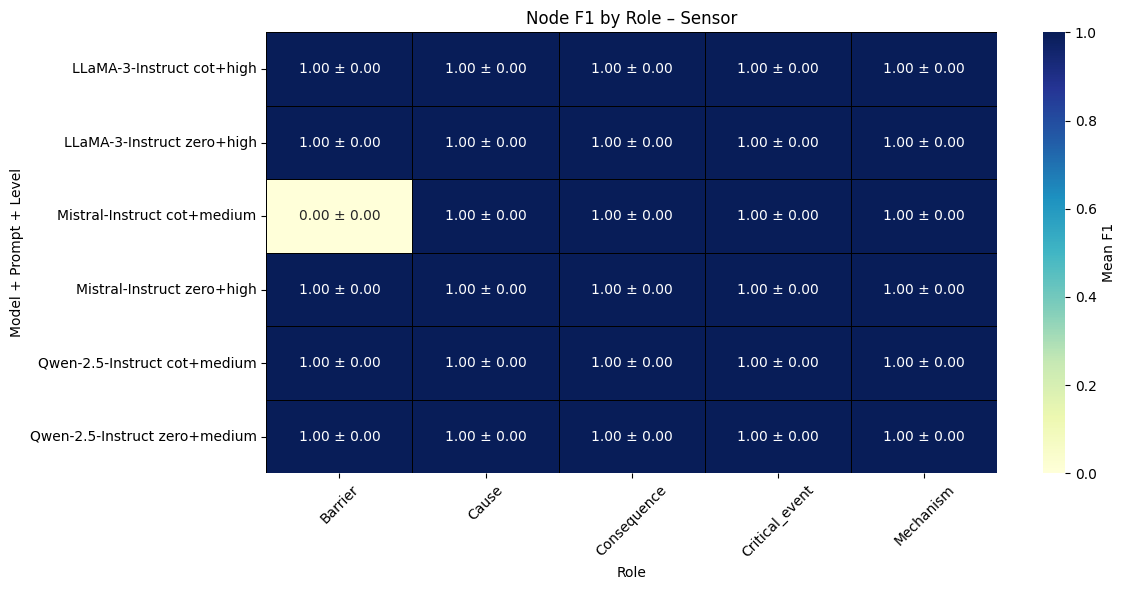

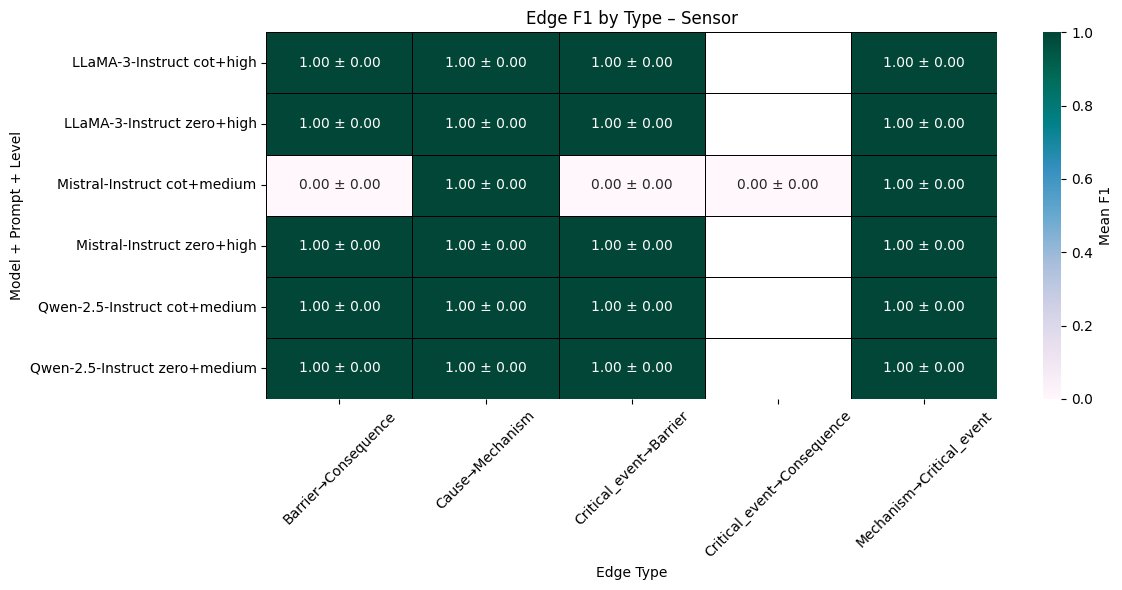

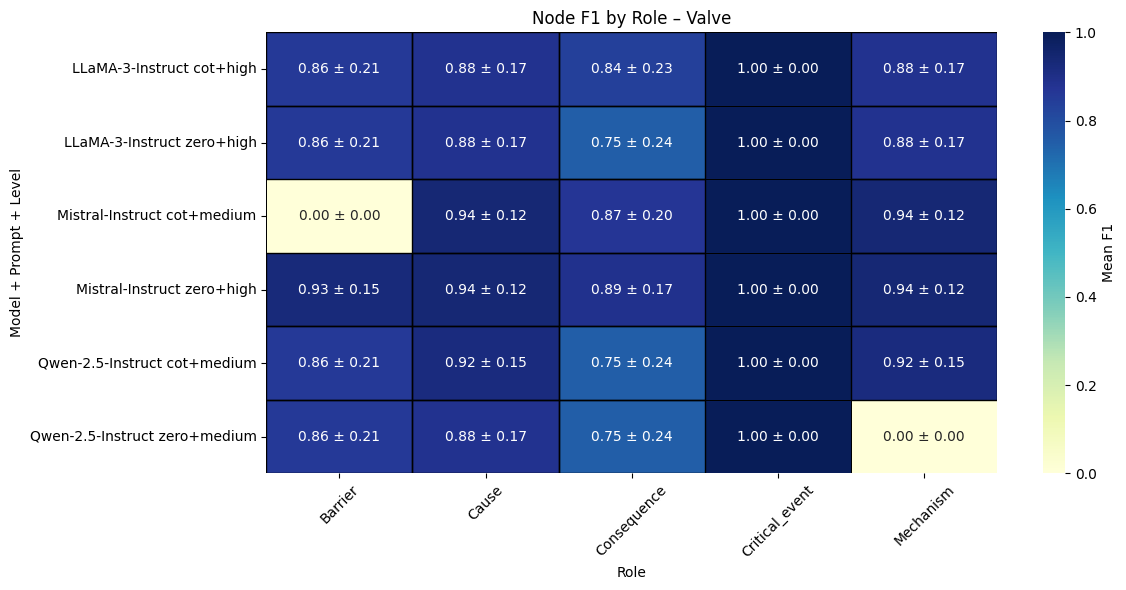

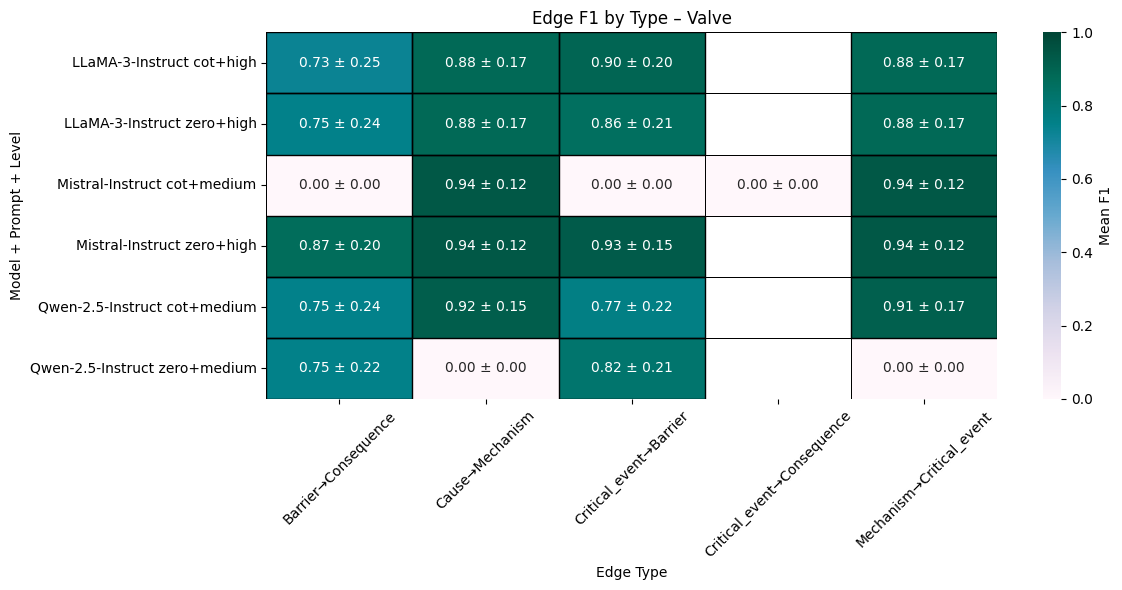

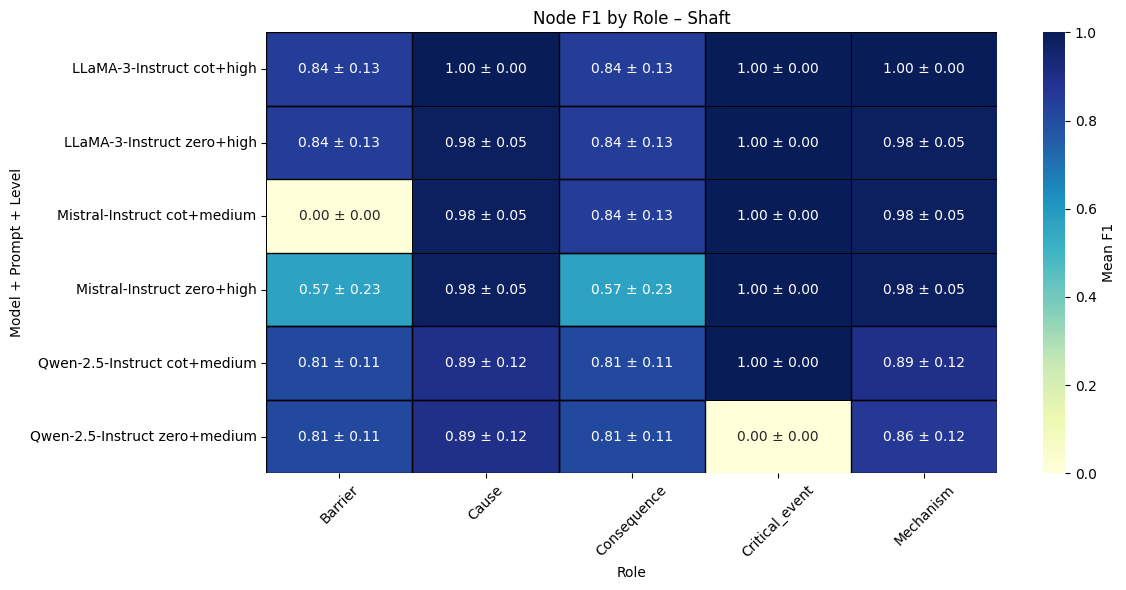

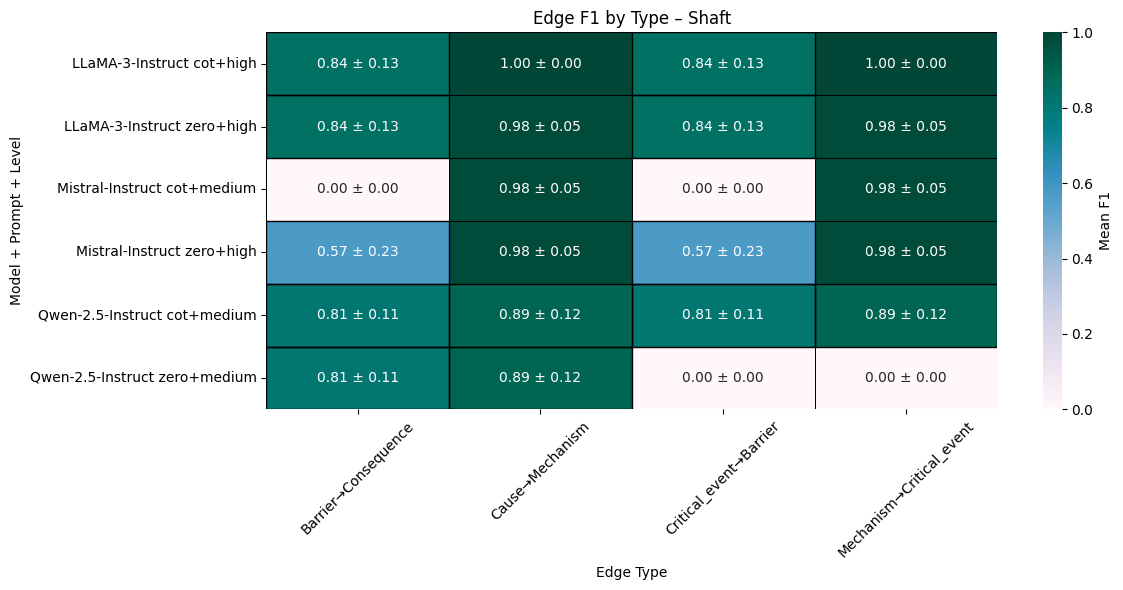

✅ All annotated heatmaps with std-based highlighting saved.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import re

# === File paths ===
files = {
    "Sensor": Path("/Users/priyank/Desktop/llm_rag/downloads/Manual_Metrics_Top_Config_Sensor.xlsx"),
    "Valve": Path("/Users/priyank/Desktop/llm_rag/downloads/Manual_Metrics_Top_Config_Valve.xlsx"),
    "Shaft": Path("/Users/priyank/Desktop/llm_rag/downloads/Manual_Metrics_Top_Config_Shaft.xlsx"),
}

# === Helper: Extract config ===
def extract_base_config(filename):
    parts = filename.split("_")
    return "_".join(parts[:3])

model_name_map = {
    "LLaMA-3-8B": "LLaMA-3-Instruct",
    "Mistral-7B": "Mistral-Instruct",
    "Qwen-7B": "Qwen-2.5-Instruct"
}

def clean_config_label(config):
    parts = config.split("_")
    model = model_name_map.get(parts[0], parts[0])
    prompt = parts[1]
    level = parts[2]
    return f"{model} {prompt}+{level}"

# === Load and aggregate ===
node_dfs, edge_dfs = [], []
for part, path in files.items():
    node = pd.read_excel(path, sheet_name="NodeMetrics")
    edge = pd.read_excel(path, sheet_name="EdgeMetrics")

    node["Part"] = part
    edge["Part"] = part

    node["Base_Config"] = node["File"].apply(extract_base_config)
    edge["Base_Config"] = edge["File"].apply(extract_base_config)

    node_dfs.append(node)
    edge_dfs.append(edge)

df_node = pd.concat(node_dfs, ignore_index=True)
df_edge = pd.concat(edge_dfs, ignore_index=True)

# Filter non-overall rows
df_node = df_node[df_node["Role"] != "Overall"]
df_edge = df_edge[df_edge["Edge Type"] != "Overall"]

# === Group by config + role/type ===
node_summary = df_node.groupby(["Part", "Base_Config", "Role"]).agg(
    Node_F1=("F1", "mean"),
    Node_F1_std=("F1", "std")
).reset_index()

edge_summary = df_edge.groupby(["Part", "Base_Config", "Edge Type"]).agg(
    Edge_F1=("F1", "mean"),
    Edge_F1_std=("F1", "std")
).reset_index()

# Clean config labels
node_summary["Base_Config"] = node_summary["Base_Config"].apply(clean_config_label)
edge_summary["Base_Config"] = edge_summary["Base_Config"].apply(clean_config_label)

# === Heatmap plot function ===
def plot_heatmap(data, index_col, col_col, mean_col, std_col, title, filename, cmap="YlGnBu", std_threshold=0.1):
    pivot_values = data.pivot(index=index_col, columns=col_col, values=mean_col)
    pivot_stds = data.pivot(index=index_col, columns=col_col, values=std_col)

    # Create annotated strings like "0.91 ± 0.04"
    annotations = pivot_values.copy().astype(str)
    mask = pivot_values.isna()

    for r in pivot_values.index:
        for c in pivot_values.columns:
            mean = pivot_values.loc[r, c]
            std = pivot_stds.loc[r, c]
            if pd.notna(mean) and pd.notna(std):
                annotations.loc[r, c] = f"{mean:.2f} ± {std:.2f}"
            else:
                annotations.loc[r, c] = ""

    # Custom cell colors: red border if std > threshold
    mask = pivot_values.isna()
    cell_colors = pivot_values.copy()
    for r in pivot_values.index:
        for c in pivot_values.columns:
            std = pivot_stds.loc[r, c]
            cell_colors.loc[r, c] = 1 if pd.notna(std) and std > std_threshold else 0

    # Plot
    plt.figure(figsize=(12, 6))
    ax = sns.heatmap(
        pivot_values, annot=annotations, fmt="", cmap=cmap,
        linewidths=0.5, linecolor='black', mask=mask,
        cbar_kws={"label": "Mean F1"}, vmin=0, vmax=1
    )

    # Highlight high-variance cells with red border
    for i in range(len(pivot_values.index)):
        for j in range(len(pivot_values.columns)):
            if cell_colors.iloc[i, j] == 1:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=1))

    plt.title(title)
    plt.ylabel("Model + Prompt + Level")
    plt.xlabel(col_col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{filename}.png", dpi=300)
    plt.show()

# === Plot all 6 heatmaps ===
for part in ["Sensor", "Valve", "Shaft"]:
    node_data = node_summary[node_summary["Part"] == part]
    edge_data = edge_summary[edge_summary["Part"] == part]

    plot_heatmap(
        node_data,
        index_col="Base_Config",
        col_col="Role",
        mean_col="Node_F1",
        std_col="Node_F1_std",
        title=f"Node F1 by Role – {part}",
        filename=f"node_f1_{part.lower()}",
        cmap="YlGnBu"
    )

    plot_heatmap(
        edge_data,
        index_col="Base_Config",
        col_col="Edge Type",
        mean_col="Edge_F1",
        std_col="Edge_F1_std",
        title=f"Edge F1 by Type – {part}",
        filename=f"edge_f1_{part.lower()}",
        cmap="PuBuGn"
    )

print("✅ All annotated heatmaps with std-based highlighting saved.")


# Older code

In [ ]:
import pandas as pd
import re
from pathlib import Path

# === File paths ===
files = {
    "Sensor": Path("/Users/priyank/Desktop/llm_rag/downloads/metrics_top_confing_sensor_v2_CORRECTED.xlsx"),
    "Valve": Path("/Users/priyank/Desktop/llm_rag/downloads/metrics_top_confing_valve_v2_CORRECTED.xlsx"),
    "Shaft": Path("/Users/priyank/Desktop/llm_rag/downloads/metrics_top_confing_shaft_v2_CORRECTED.xlsx"),
}
# === Helper functions ===
def extract_base_config(filename):
    return re.sub(r'_seed\d\d?_.*$', '', filename)

def process_stochastic_file(file_path, part):
    xls = pd.ExcelFile(file_path)
    df_node = xls.parse("NodeMetrics")
    df_edge = xls.parse("EdgeMetrics")
    df_ged = xls.parse("GEDMetrics")

    df_edge = df_edge[df_edge["Edge Type"] == "Overall"]

    # Average Node, Edge F1, GED per seed file
    node_avg = df_node.groupby("File").agg(Node_F1=("F1", "mean")).reset_index()
    edge_avg = df_edge.groupby("File").agg(Edge_F1=("F1", "mean")).reset_index()
    ged_avg = df_ged.groupby("File").agg(GED=("GED", "mean")).reset_index()

    # Merge and extract metadata
    df = node_avg.merge(edge_avg, on="File", how="outer").merge(ged_avg, on="File", how="outer")
    df["Config"] = df["File"].apply(extract_base_config)
    df["Model"] = df["Config"].apply(lambda x: x.split("_")[0])
    df["Prompt_Type"] = df["Config"].apply(lambda x: x.split("_")[1])
    df["Strictness"] = df["Config"].apply(lambda x: x.split("_")[2])
    df["Part"] = part
    return df

# === Collect all seed-level summaries ===
all_seeds = [process_stochastic_file(path, part) for part, path in files.items()]
df_all = pd.concat(all_seeds, ignore_index=True)

# === Group by config + part to compute variability across seeds ===
grouped = df_all.groupby(["Model", "Prompt_Type", "Strictness", "Part"]).agg(
    Mean_Node_F1=("Node_F1", "mean"),
    Std_Node_F1=("Node_F1", "std"),
    Mean_Edge_F1=("Edge_F1", "mean"),
    Std_Edge_F1=("Edge_F1", "std"),
    Mean_GED=("GED", "mean"),
    Std_GED=("GED", "std")
).reset_index()

grouped = grouped.round(3)

# === Save full output ===
grouped.to_csv("stochasticity_summary_by_part_v3.csv", index=False)

# === Split into one table per part if needed
for part_name in grouped["Part"].unique():
    part_table = grouped[grouped["Part"] == part_name]
    part_table.to_csv(f"stochasticity_summary_{part_name.lower()}.csv", index=False)
    print(f"\n=== {part_name.upper()} ===\n")
    print(part_table)


In [ ]:
# import pandas as pd
# import re
# from pathlib import Path

# # === File paths: adjust these to your local paths if needed
# files = {
#     "Sensor": Path("/Users/priyank/Desktop/llm_rag/downloads/Manual_Metrics_Top_Config_Sensor.xlsx"),
#     "Valve": Path("/Users/priyank/Desktop/llm_rag/downloads/Manual_Metrics_Top_Config_Valve.xlsx"),
#     "Shaft": Path("/Users/priyank/Desktop/llm_rag/downloads/Manual_Metrics_Top_Config_Shaft.xlsx"),
# }

# # === Helper functions ===
# def extract_base_config(filename):
#     return re.sub(r'_seed\d\d?_.*$', '', filename)

# def process_stochastic_file(file_path, part):
#     xls = pd.ExcelFile(file_path)
#     df_node = xls.parse("NodeMetrics")
#     df_edge = xls.parse("EdgeMetrics")
#     df_ged = xls.parse("GEDMetrics")

#     # Use only 'Overall' rows for node and edge
#     df_node = df_node[df_node["Role"] == "Overall"]
#     df_edge = df_edge[df_edge["Edge Type"] == "Overall"]

#     node_avg = df_node.groupby("File").agg(Node_F1=("F1", "mean")).reset_index()
#     edge_avg = df_edge.groupby("File").agg(Edge_F1=("F1", "mean")).reset_index()
#     ged_avg = df_ged.groupby("File").agg(GED=("GED", "mean")).reset_index()

#     df = node_avg.merge(edge_avg, on="File", how="outer").merge(ged_avg, on="File", how="outer")
#     df["Config"] = df["File"].apply(extract_base_config)
#     df["Model"] = df["Config"].apply(lambda x: x.split("_")[0])
#     df["Prompt_Type"] = df["Config"].apply(lambda x: x.split("_")[1])
#     df["Strictness"] = df["Config"].apply(lambda x: x.split("_")[2])
#     df["Part"] = part
#     return df

# # === Process all parts
# all_dfs = [process_stochastic_file(path, part) for part, path in files.items()]
# df_all = pd.concat(all_dfs, ignore_index=True)

# summary = df_all.groupby(["Model", "Prompt_Type", "Strictness", "Part"]).agg(
#     Mean_Node_F1=("Node_F1", "mean"),
#     Std_Node_F1=("Node_F1", "std"),
#     Mean_Edge_F1=("Edge_F1", "mean"),
#     Std_Edge_F1=("Edge_F1", "std"),
#     Mean_GED=("GED", "mean"),
#     Std_GED=("GED", "std")
# ).reset_index().round(3)

# # === LaTeX table output
# def format_latex_table(df, part):
#     rows = []
#     for _, row in df.iterrows():
#         rows.append(
#             f"{row['Model']} & {row['Prompt_Type']} & {row['Strictness']} & "
#             f"{row['Mean_Node_F1']} $\\pm$ {row['Std_Node_F1']} & "
#             f"{row['Mean_Edge_F1']} $\\pm$ {row['Std_Edge_F1']} & "
#             f"{row['Mean_GED']} $\\pm$ {row['Std_GED']} \\\\"
#         )
#     return f"""\\begin{{table}}[!h]
# \\centering
# \\begin{{tabular}}{{lcccccc}}
# \\toprule
# \\textbf{{Model}} & \\textbf{{Prompt}} & \\textbf{{Level}} & \\textbf{{Node F1}} & \\textbf{{Edge F1}} & \\textbf{{GED}} \\\\
# \\midrule
# {chr(10).join(rows)}
# \\bottomrule
# \\end{{tabular}}
# \\caption{{Stochastic summary for {part} across 10 seeds (Overall-level only).}}
# \\label{{tab:stochastic_{part.lower()}}}
# \\end{{table}}"""

# # Generate and print LaTeX tables for each part
# for part in summary["Part"].unique():
#     print(f"\n% === LaTeX table for {part} ===\n")
#     print(format_latex_table(summary[summary["Part"] == part], part))


In [ ]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# from pathlib import Path
# import re

# files = {
#     "Sensor": Path("/Users/priyank/Desktop/llm_rag/downloads/Manual_Metrics_Top_Config_Sensor.xlsx"),
#     "Valve": Path("/Users/priyank/Desktop/llm_rag/downloads/Manual_Metrics_Top_Config_Valve.xlsx"),
#     "Shaft": Path("/Users/priyank/Desktop/llm_rag/downloads/Manual_Metrics_Top_Config_Shaft.xlsx"),
# }


# # === Helper: Extract base config (model + prompt + level) ===
# def extract_base_config(filename):
#     return re.sub(r'_seed\d\d?_.*$', '', filename)

# # === Load Node and Edge metrics ===
# node_dfs, edge_dfs = [], []
# for part, path in files.items():
#     node = pd.read_excel(path, sheet_name="NodeMetrics")
#     edge = pd.read_excel(path, sheet_name="EdgeMetrics")

#     node["Part"] = part
#     edge["Part"] = part

#     node["Base_Config"] = node["File"].apply(extract_base_config)
#     edge["Base_Config"] = edge["File"].apply(extract_base_config)

#     node_dfs.append(node)
#     edge_dfs.append(edge)

# df_node = pd.concat(node_dfs, ignore_index=True)
# df_edge = pd.concat(edge_dfs, ignore_index=True)

# df_node = df_node[df_node["Role"] != "Overall"]
# df_edge = df_edge[df_edge["Edge Type"] != "Overall"]

# # === Aggregate F1 scores by role/type ===
# node_summary = df_node.groupby(["Part", "Base_Config", "Role"]).agg(
#     Node_F1=("F1", "mean")
# ).reset_index()

# edge_summary = df_edge.groupby(["Part", "Base_Config", "Edge Type"]).agg(
#     Edge_F1=("F1", "mean")
# ).reset_index()

# # === Plot and save heatmaps ===
# sns.set_theme(style="whitegrid")
# plt.rcParams.update({
#     "font.size": 18,
#     "axes.titlesize": 20,
#     "axes.labelsize": 20,
#     "xtick.labelsize": 15,
#     "ytick.labelsize": 15
# })

# def plot_heatmap(data, index_col, col_col, val_col, title, filename, cmap="YlGnBu"):
#     pivot = data.pivot(index=index_col, columns=col_col, values=val_col)
#     plt.figure(figsize=(12, 6))
#     sns.heatmap(pivot, annot=True, fmt=".2f", cmap=cmap, linewidths=0.5)
#     plt.title(title)
#     plt.ylabel("Model + Prompt + Level")
#     plt.xlabel(col_col)
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.savefig(f"{filename}.png", dpi=300)
#     plt.show()

# # Map model names to publication-style names
# model_name_map = {
#     "LLaMA-3-8B": "LLaMA-3-Instruct",
#     "Mistral-7B": "Mistral-Instruct",
#     "Qwen-7B": "Qwen-2.5-Instruct"
# }

# def clean_config_label(config):
#     parts = config.split("_")
#     model = model_name_map.get(parts[0], parts[0])
#     prompt = parts[1]
#     level = parts[2]
#     return f"{model} {prompt}+{level}"

# # Apply mapping
# node_summary["Base_Config"] = node_summary["Base_Config"].apply(clean_config_label)
# edge_summary["Base_Config"] = edge_summary["Base_Config"].apply(clean_config_label)


# # === Generate 6 heatmaps: 2 per part ===
# for part in ["Sensor", "Valve", "Shaft"]:
#     # Node F1
#     node_data = node_summary[node_summary["Part"] == part]
#     plot_heatmap(
#         node_data,
#         index_col="Base_Config",
#         col_col="Role",
#         val_col="Node_F1",
#         title=f"Node F1 by Role – {part}",
#         filename=f"node_f1_{part.lower()}",
#         cmap="YlGnBu"
#     )

#     # Edge F1
#     edge_data = edge_summary[edge_summary["Part"] == part]
#     plot_heatmap(
#         edge_data,
#         index_col="Base_Config",
#         col_col="Edge Type",
#         val_col="Edge_F1",
#         title=f"Edge F1 by Type – {part}",
#         filename=f"edge_f1_{part.lower()}",
#         cmap="PuBuGn"
#     )

# print("✅ Saved all 6 heatmaps as PNGs in current directory.")
